使用 LangGraph 构建一个多智能体系统：  
一个路由智能体（Router）接收用户问题，将其拆分为针对不同领域的子任务，并行分发给专门的专家智能体（GitHub、Notion、Slack），最后由汇总节点合成最终答案。
```mermaid
graph LR
    A([用户查询]) --> B[分类/路由层]
    B --> C[GitHub 专家]
    B --> D[Notion 专家]
    B --> E[Slack 专家]
    C --> F[结果综合层]
    D --> F
    E --> F
    F --> G([最终回答])
```
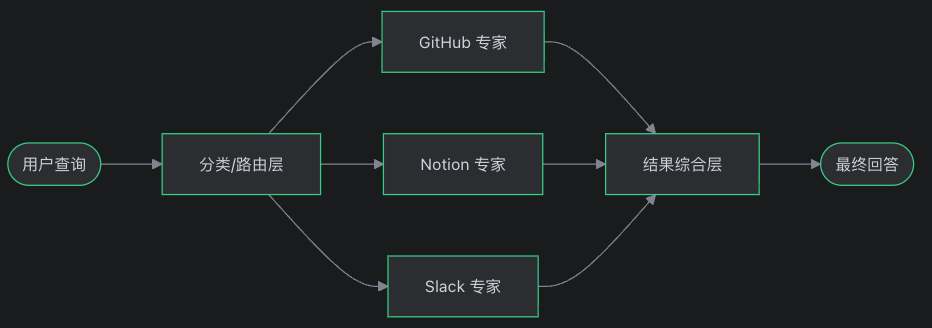

In [ ]:
import operator
from typing import Annotated, Literal, TypedDict

from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from pydantic import BaseModel, Field

# ----------------------------------------------------------------
# 1. 状态定义 (State Definitions)
# ----------------------------------------------------------------

class AgentInput(TypedDict):
    """子智能体的输入状态"""
    query: str

class AgentOutput(TypedDict):
    """子智能体的输出结果"""
    source: str
    result: str

class Classification(TypedDict):
    """路由决策：哪个智能体处理哪个查询"""
    source: Literal["github", "notion", "slack"]
    query: str

class RouterState(TypedDict):
    """主图的状态"""
    query: str
    classifications: list[Classification]
    # 使用 Annotated 和 operator.add 来实现并行结果的累加（Reducer）
    results: Annotated[list[AgentOutput], operator.add]
    final_answer: str

class ClassificationResult(BaseModel):
    """分类器的结构化输出架构"""
    classifications: list[Classification] = Field(
        description="要调用的智能体列表及其针对性的子查询"
    )

# ----------------------------------------------------------------
# 2. 工具定义 (Mock Tools)
# ----------------------------------------------------------------

@tool
def search_code(query: str, repo: str = "main") -> str:
    """在 GitHub 代码库中搜索代码。"""
    return f"在 {repo} 中找到匹配 '{query}' 的代码：src/auth.py 中的身份验证中间件。"

@tool
def search_issues(query: str) -> str:
    """搜索 GitHub Issues 和 Pull Requests。"""
    return f"找到 3 个匹配 '{query}' 的 Issue：#142 (API 文档), #89 (OAuth 流程)。"

@tool
def search_notion(query: str) -> str:
    """在 Notion 工作区搜索文档。"""
    return f"找到文档：'API 认证指南' - 涵盖 OAuth2 流程、API Key 和 JWT。"

@tool
def search_slack(query: str) -> str:
    """搜索 Slack 消息和频道讨论。"""
    return f"在 #engineering 频道找到讨论：'使用 Bearer token 进行 API 认证'。"

# ----------------------------------------------------------------
# 3. 模型与专家智能体初始化
# ----------------------------------------------------------------

# 初始化模型 (请确保已设置 OPENAI_API_KEY)
model = init_chat_model("openai:gpt-4o")
router_llm = init_chat_model("openai:gpt-4o-mini")

# 创建专门的专家智能体
github_agent = create_agent(
    model,
    tools=[search_code, search_issues],
    system_prompt="你是一个 GitHub 专家。通过搜索仓库和 Issue 来回答代码实现细节问题。"
)

notion_agent = create_agent(
    model,
    tools=[search_notion],
    system_prompt="你是一个 Notion 专家。通过搜索组织文档回答内部流程和政策问题。"
)

slack_agent = create_agent(
    model,
    tools=[search_slack],
    system_prompt="你是一个 Slack 专家。通过搜索团队讨论记录回答非正式知识共享问题。"
)

# ----------------------------------------------------------------
# 4. 节点函数 (Workflow Nodes)
# ----------------------------------------------------------------

def classify_query(state: RouterState) -> dict:
    """分类查询并决定调用哪些智能体"""
    structured_llm = router_llm.with_structured_output(ClassificationResult)
    
    system_msg = """分析查询并决定咨询哪些知识库。
针对每个相关来源，生成一个优化的子问题。
来源包括：github (代码/技术), notion (文档/政策), slack (讨论/即时消息)。
仅返回相关的来源。"""
    
    result = structured_llm.invoke([
        {"role": "system", "content": system_msg},
        {"role": "user", "content": state["query"]}
    ])
    return {"classifications": result.classifications}

def route_to_agents(state: RouterState) -> list[Send]:
    """根据分类结果扇出（Fan-out）到各个专家节点"""
    return [
        Send(c["source"], {"query": c["query"]})
        for c in state["classifications"]
    ]

def query_github(state: AgentInput) -> dict:
    """调用 GitHub 专家智能体"""
    res = github_agent.invoke({"messages": [("user", state["query"])]})
    return {"results": [{"source": "github", "result": res["messages"][-1].content}]}

def query_notion(state: AgentInput) -> dict:
    """调用 Notion 专家智能体"""
    res = notion_agent.invoke({"messages": [("user", state["query"])]})
    return {"results": [{"source": "notion", "result": res["messages"][-1].content}]}

def query_slack(state: AgentInput) -> dict:
    """调用 Slack 专家智能体"""
    res = slack_agent.invoke({"messages": [("user", state["query"])]})
    return {"results": [{"source": "slack", "result": res["messages"][-1].content}]}

def synthesize_results(state: RouterState) -> dict:
    """综合所有专家的结果并生成最终答案"""
    if not state["results"]:
        return {"final_answer": "未从任何来源找到相关信息。"}

    formatted_results = "\n\n".join([
        f"**来自 {r['source'].upper()}:**\n{r['result']}" 
        for r in state["results"]
    ])
    
    synthesis_prompt = f"""针对用户原始问题："{state['query']}"，综合以下搜索结果。
- 合并多源信息，去除冗余。
- 突出最相关的操作建议。
- 保持简洁且有条理。"""
    
    response = router_llm.invoke([
        {"role": "system", "content": synthesis_prompt},
        {"role": "user", "content": formatted_results}
    ])
    return {"final_answer": response.content}

# ----------------------------------------------------------------
# 5. 构建与编译图 (Graph Construction)
# ----------------------------------------------------------------

workflow = StateGraph(RouterState)

# 添加节点
workflow.add_node("classify", classify_query)
workflow.add_node("github", query_github)
workflow.add_node("notion", query_notion)
workflow.add_node("slack", query_slack)
workflow.add_node("synthesize", synthesize_results)

# 设置边
workflow.add_edge(START, "classify")
# 条件边：根据分类结果并行分发到 github, notion, slack 节点
workflow.add_conditional_edges(
    "classify", 
    route_to_agents, 
    ["github", "notion", "slack"]
)
# 所有专家节点处理完后汇聚到综合节点
workflow.add_edge("github", "synthesize")
workflow.add_edge("notion", "synthesize")
workflow.add_edge("slack", "synthesize")
workflow.add_edge("synthesize", END)

# 编译
app = workflow.compile()

# ----------------------------------------------------------------
# 6. 运行示例
# ----------------------------------------------------------------

if __name__ == "__main__":
    inputs = {"query": "我该如何验证 API 请求？"}
    result = app.invoke(inputs)
    
    print(f"\n用户提问: {result['query']}")
    print("\n--- 路由决策 ---")
    for c in result['classifications']:
        print(f"调用 {c['source']}: {c['query']}")
        
    print("\n--- 最终综合答案 ---")
    print(result['final_answer'])